<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_skew_correction_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-04-10 19:42:25 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed VersionParsing ── v1.3.0
   Installed Parsers ───────── v2.8.1
   Installed Conda ─────────── v1.10.0
   Installed PyCall ────────── v1.96.4
   Installed MacroTools ────── v0.5.13
   Installed JSON ──────────── v0.21.4
   Installed Preferences ───── v1.4.3
   Installed PrecompileTools ─ v1.2.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.0
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c

Install PySR and PyTorch-Lightning:

In [2]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.9 MB/s eta 0:00:00


In [3]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.3 MB/s eta 0:00:00


In [1]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [1]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

/usr/local/lib/python3.10/dist-packages/pysr/deprecated.py:9: FutureWarning: The `install` function has been removed. PySR now uses the `juliacall` package to install its dependencies automatically at import time. 
  warnings.warn(


In [2]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/psc_i.csv')

In [4]:
print(df.head(5))

                             model  skew girderName   L   D  w_oh    ts  S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85     0       Tx28  42  28   1.5   8.5  6   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100     0       Tx28  42  28   1.5  10.0  6   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85     0       Tx28  42  28   2.0   8.5  6   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100     0       Tx28  42  28   2.0  10.0  6   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85     0       Tx28  42  28   2.5   8.5  6   

   Nb           Kg  ...     n_bm4      n_r1      n_r2      n_r3      n_r4  \
0   4  555508.7064  ...  0.000520  0.925505  0.086994  0.026596 -0.039095   
1   4  588747.3095  ...  0.000889  0.923853  0.093144  0.036185 -0.053182   
2   4  555508.7064  ...  0.000448  0.993568  0.023006  0.024837 -0.041411   
3   4  588747.3095  ...  0.000803  0.991692  0.031001  0.033527 -0.056219   
4   4  555508.7064  ...  0.000379  1.060984 -0.039607  0.022209 -0.043585   

     sum_RY      d-G1      d-G2      d-G3          d-G4  
0  0.00003

In [68]:
import numpy as np

df['x_trial'] = ((df['S']+df['w_oh'])*np.tan(np.radians(df['skew'])))/df['L']*df['D']/28
L = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'L'].values
D = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'D'].values
S = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'S'].values
w_oh = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'w_oh'].values
ts = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'ts'].values
Nb = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Nb'].values
Kg = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Kg'].values
skew = df.loc[(df['skew'] == 60), 'skew'].values


n_r1_sk0 = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'n_r1'].values
n_r1_sk30 = df.loc[(df['skew'] == 30), 'n_r1'].values
n_r1_sk45 = df.loc[(df['skew'] == 45), 'n_r1'].values
n_r1_sk60 = df.loc[(df['skew'] == 60), 'n_r1'].values

x_trial = df.loc[(df['skew'] == 30), 'x_trial'].values

sk30_r1_correction = n_r1_sk30 / n_r1_sk0


In [ ]:
# sample data from lever rule
# n_r1 = (w_oh + S) / S

In [70]:
X = np.stack((L, w_oh, S, skew, D, x_trial), axis=-1)
y = sk30_r1_correction
print(X.shape)
print(y.shape)

(1152, 6)
(1152,)


In [ ]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "tan", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-1,1),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

In [ ]:
model.sympy()

In [ ]:
y_pred = model.predict(X)

print("Default selection MSE:", np.power(n_r1_pred - y, 2).mean())

In [ ]:
x_line = [0.9, 1.2]
y_line = [0.9, 1.2]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.2))
plt.ylim((0.9,1.2))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [ ]:
model.latex()

$0.757 + \frac{1}{\sqrt{\frac{x_{0}^{2}}{x_{1}^{2} x_{3}}}}$

$0.757 + \frac{w_{oh} D^{0.5}}{L}$

$\left(\frac{L^{2}}{w_{oh}^{2} {D} \sqrt{S}}\right)^{-0.290} + 0.575$

In [ ]:
y2 = n_r2

model.fit(X, y2)

print(model)


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1886: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:231: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:109: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warni

Started!

Expressions evaluated per second: 6.900e+03
Head worker occupation: 0.3%
Progress: 16 / 1500 total iterations (1.067%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.203e-03  1.594e+01  y = -9.1418e-05
2           4.863e-03  2.434e-01  y = inv(x₃)
4           4.491e-03  3.978e-02  y = inv(square(square(2.2653)))
5           3.029e-03  3.939e-01  y = inv(2.2653 + cube(x₁))
6           2.327e-03  2.637e-01  y = inv(square(2.2653) + cube(x₁))
7           2.139e-03  8.415e-02  y = (((x₁ ^ x₁) + 1.8752) ^ -1.3952)
9           2.100e-03  9.233e-03  y = inv((cube(x₁) + sqrt(x₂)) * sqrt(x₁))
10          1.881e-03  1.103e-01  y = (((inv(x₁) + (x₁ ^ x₁)) + 1.8752) ^ -1.3952)
14          1.880e-03  5.873e-05  y = (((inv(sqrt(cube(x₁) + -0.6576)) + (x₁ ^ x₁)) + 1.8752) ^ ...
                                  -1.3952)
15          1.291e-03  3.762e-01  y = ((((physics(

In [ ]:
model.sympy()

(-0.74106324 + x1**2/x0)**6 - x1**2*x3**2/x0**3

In [ ]:
n_r2_pred = model.predict(X)

print("Default selection MSE:", np.power(n_r2_pred - y2, 2).mean())

Default selection MSE: 0.00022245335746704246


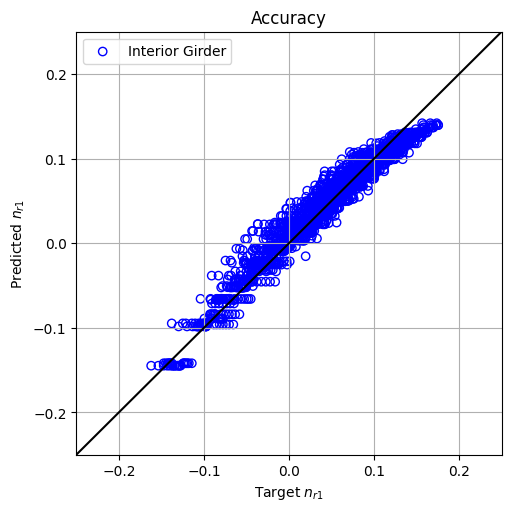

In [ ]:
x_line = [-0.25, 0.25]
y_line = [-0.25, 0.25]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_r2, y=n_r2_pred, marker='o', c='none', edgecolor='b', label='Interior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((-0.25, 0.25))
plt.ylim((-0.25, 0.25))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [ ]:
model.latex()

'\\left(-0.741 + \\frac{x_{1}^{2}}{x_{0}}\\right)^{6} - \\frac{x_{1}^{2} x_{3}^{2}}{x_{0}^{3}}'

$ \frac{x_{1}^{2}}{x_{0} - \frac{x_{3}}{x_{1}}} + 0.167 $

$ \frac{w_{oh}^{2}}{L - \frac{D}{w_{oh}}} + 0.167 $